In [1]:

import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from pyjarowinkler import distance
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import tensorflow 
import tensorflow as tf
import scipy
import sklearn
import tqdm

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Add,Reshape,Lambda
from keras.layers import Flatten,Input,Bidirectional,LSTMCell,TimeDistributed
from keras.utils import to_categorical,plot_model
from keras.utils.vis_utils import model_to_dot	
from IPython.display import SVG
from tensorflow import set_random_seed

T=4
d=50
batch_size=3
n_a=2
np.random.seed(1)
set_random_seed(1)

x=np.random.rand(batch_size,T,d)


Using TensorFlow backend.


## case 1 : sequence length =T , input 1

In [3]:
np.random.seed(1)
#set_random_seed(1)

i=Input(shape=(T,d))
lstm1=LSTM(n_a,return_state=False,return_sequences=True)(i)
lstm1=LSTM(n_a,return_state=False,return_sequences=True)(lstm1)
model1=Model(inputs=i,outputs=lstm1)
model1.summary()
model1.predict(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 2)              424       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 2)              40        
Total params: 464
Trainable params: 464
Non-trainable params: 0
_________________________________________________________________


array([[[0.03153282, 0.02195749],
        [0.06709555, 0.04790732],
        [0.10086724, 0.06961383],
        [0.11506429, 0.08126175]],

       [[0.03432832, 0.0336638 ],
        [0.06833646, 0.05452058],
        [0.11184714, 0.07736374],
        [0.13139614, 0.08437069]],

       [[0.02254318, 0.02476908],
        [0.06191476, 0.05725384],
        [0.09719618, 0.07639652],
        [0.12731677, 0.08975205]]], dtype=float32)

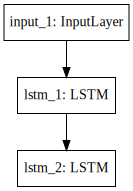

In [4]:
SVG(model_to_dot(model1).create(prog='dot', format='svg'))


In [20]:
W1=model1.get_weights()

## case 2, T inputs

Tensor("lstm_4/while/Exit_3:0", shape=(?, 2), dtype=float32)
Tensor("lstm_4_1/while/Exit_3:0", shape=(?, 2), dtype=float32)
Tensor("lstm_4_2/while/Exit_3:0", shape=(?, 2), dtype=float32)
Tensor("lstm_4_3/while/Exit_3:0", shape=(?, 2), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1, 50)        0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 (None, 2)            0                                            
_________________________________________________________

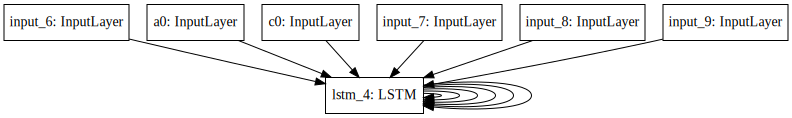

In [21]:
np.random.seed(1)
set_random_seed(1)

ilayers=[]
os=[]
lstm_layer=LSTM(n_a,return_state=True,return_sequences=True)
a0 = Input(shape=(n_a,), name='a0')
c0 = Input(shape=(n_a,), name='c0')
a = a0
c = c0
for i in range(T):
    I=Input(shape=(1,d))
    ilayers.append(I)
    a,a,c=lstm_layer(I,initial_state=[a,c])
    os.append(a)
    print(a)
model2=Model(inputs=ilayers+[a0,c0],outputs=os)
model2.summary()
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [23]:
W2=model2.get_weights()
for i,j in enumerate(W2):
    print(i)
    assert W1[i].all()==W2[i].all()

0
1
2


In [24]:
a0.shape

TensorShape([Dimension(None), Dimension(2)])

### converting Input to a new shape for model2, expect differently shape output as well

In [25]:
xinputs=[x[:,i,:].reshape(batch_size,1,d) for i in range(T)]
a0=np.zeros((batch_size, n_a))
c0=np.zeros((batch_size, n_a))
model2.predict(xinputs +  [a0,c0])########## we get same output

[array([[-0.22238015, -0.07705454],
        [-0.20868695, -0.20530409],
        [-0.12552582, -0.15437095]], dtype=float32),
 array([[-0.32714635, -0.17777373],
        [-0.32979804, -0.14818689],
        [-0.31344017, -0.26297227]], dtype=float32),
 array([[-0.40802687, -0.22108075],
        [-0.51170135, -0.22082141],
        [-0.41150817, -0.19334342]], dtype=float32),
 array([[-0.31120545, -0.25554833],
        [-0.40107614, -0.16624847],
        [-0.46445066, -0.22514418]], dtype=float32)]

In [26]:
model1.predict(x)

array([[[0.03153282, 0.02195749],
        [0.06709555, 0.04790732],
        [0.10086724, 0.06961383],
        [0.11506429, 0.08126175]],

       [[0.03432832, 0.0336638 ],
        [0.06833646, 0.05452058],
        [0.11184714, 0.07736374],
        [0.13139614, 0.08437069]],

       [[0.02254318, 0.02476908],
        [0.06191476, 0.05725384],
        [0.09719618, 0.07639652],
        [0.12731677, 0.08975205]]], dtype=float32)

## Case 3, 1 Input, but Lambda splitting

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 16, 2500, 77) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50)           0           input_13[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 50)        0           lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
                                                                 lambda_4[0][0]                   
__________

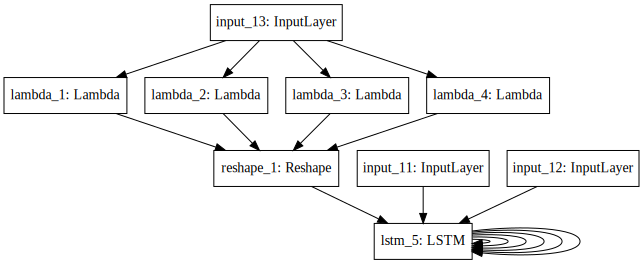

In [27]:
np.random.seed(1)
set_random_seed(1)

I=Input(shape=(T,d))
a0=Input(shape=(n_a,))
c0=Input(shape=(n_a,))

randomI=Input(shape=(T*T,d*d,77))

lstm3=LSTM(n_a,return_state=True,return_sequences=False)
a=a0
c=c0

reshapor = Reshape((1, d))
otensors=[]
for i in range(T):
    it = Lambda(lambda doesnt_matter: I[:,i,:])(randomI)##NOTE looks like what randomI is doesnt matter, it takes value only from I[:,i,:]
    #it=I[:,i,:]#, as I understand Slicing a tensor lacks properties of a tensor a "layer" outputs and hence wont work
    it=reshapor(it)
    a,_,c=lstm3(it,initial_state=[a,c])
    otensors.append(a)
model3=Model(inputs=[I,a0,c0,randomI],outputs=otensors)
model3.summary()
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [28]:
a0=np.zeros((batch_size, n_a))
c0=np.zeros((batch_size, n_a))
ri=np.random.rand(batch_size,T*T,d*d,77)
model3.predict([x,a0,c0,ri])#########same as before, but imporper shape

[array([[-0.22238015, -0.07705454],
        [-0.20868695, -0.20530409],
        [-0.12552582, -0.15437095]], dtype=float32),
 array([[-0.32714635, -0.17777373],
        [-0.32979804, -0.14818689],
        [-0.31344017, -0.26297227]], dtype=float32),
 array([[-0.40802687, -0.22108075],
        [-0.51170135, -0.22082141],
        [-0.41150817, -0.19334342]], dtype=float32),
 array([[-0.31120545, -0.25554833],
        [-0.40107614, -0.16624847],
        [-0.46445066, -0.22514418]], dtype=float32)]

In [29]:
[x,a0,c0][0].shape

(3, 4, 50)

Please **NOTE** that going through model2 or model3 will return as a list of each time step output, as in a list of each element of shape 
``` 
        BATCH_SIZE x D , or T x BATCH_SIZE x D
``` 
whereas model1 gives
``` 
        BATCH_SIZE x T x D 
``` 
(same shape as Input)

In [30]:
model1.predict(x)

array([[[0.03153282, 0.02195749],
        [0.06709555, 0.04790732],
        [0.10086724, 0.06961383],
        [0.11506429, 0.08126175]],

       [[0.03432832, 0.0336638 ],
        [0.06833646, 0.05452058],
        [0.11184714, 0.07736374],
        [0.13139614, 0.08437069]],

       [[0.02254318, 0.02476908],
        [0.06191476, 0.05725384],
        [0.09719618, 0.07639652],
        [0.12731677, 0.08975205]]], dtype=float32)

In [31]:
model2.predict([x[:,i,:].reshape(x.shape[0],1,d) for i in range(T)]+[np.zeros((batch_size, n_a)),np.zeros((batch_size, n_a))])

[array([[-0.22238015, -0.07705454],
        [-0.20868695, -0.20530409],
        [-0.12552582, -0.15437095]], dtype=float32),
 array([[-0.32714635, -0.17777373],
        [-0.32979804, -0.14818689],
        [-0.31344017, -0.26297227]], dtype=float32),
 array([[-0.40802687, -0.22108075],
        [-0.51170135, -0.22082141],
        [-0.41150817, -0.19334342]], dtype=float32),
 array([[-0.31120545, -0.25554833],
        [-0.40107614, -0.16624847],
        [-0.46445066, -0.22514418]], dtype=float32)]

In [32]:
##